In [1]:
from torch import Tensor
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import Dataset
import random
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import os
from pathlib import Path
import shutil

In [2]:
import torch
import numpy as np
import math


def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])


def compute_cc_weights(nb_steps):
    lam = np.arange(0, nb_steps + 1, 1).reshape(-1, 1)
    lam = np.cos((lam @ lam.T) * math.pi / nb_steps)
    lam[:, 0] = .5
    lam[:, -1] = .5 * lam[:, -1]
    lam = lam * 2 / nb_steps
    W = np.arange(0, nb_steps + 1, 1).reshape(-1, 1)
    W[np.arange(1, nb_steps + 1, 2)] = 0
    W = 2 / (1 - W ** 2)
    W[0] = 1
    W[np.arange(1, nb_steps + 1, 2)] = 0
    cc_weights = torch.tensor(lam.T @ W).float()
    steps = torch.tensor(np.cos(np.arange(0, nb_steps + 1, 1).reshape(-1, 1) * math.pi / nb_steps)).float()

    return cc_weights, steps


def integrate(x0, nb_steps, step_sizes, integrand, h, compute_grad=False, x_tot=None, inv_f=False):
    #Clenshaw-Curtis Quadrature Method
    cc_weights, steps = compute_cc_weights(nb_steps)

    device = x0.get_device() if x0.is_cuda or x0.is_mps else "cpu"
    if x0.is_mps:
        device = 'mps'

    cc_weights, steps = cc_weights.to(device), steps.to(device)

    xT = x0 + nb_steps*step_sizes
    if not compute_grad:
        x0_t = x0.unsqueeze(1).expand(-1, nb_steps + 1, -1)
        xT_t = xT.unsqueeze(1).expand(-1, nb_steps + 1, -1)
        h_steps = h.unsqueeze(1).expand(-1, nb_steps + 1, -1)
        steps_t = steps.unsqueeze(0).expand(x0_t.shape[0], -1, x0_t.shape[2])
        X_steps = x0_t + (xT_t-x0_t)*(steps_t + 1)/2
        X_steps = X_steps.contiguous().view(-1, x0_t.shape[2])
        h_steps = h_steps.contiguous().view(-1, h.shape[1])
        if inv_f:
            dzs = 1/integrand(X_steps, h_steps)
        else:
            dzs = integrand(X_steps, h_steps)
        dzs = dzs.view(xT_t.shape[0], nb_steps+1, -1)
        dzs = dzs*cc_weights.unsqueeze(0).expand(dzs.shape)
        z_est = dzs.sum(1)
        return z_est*(xT - x0)/2
    else:

        x0_t = x0.unsqueeze(1).expand(-1, nb_steps + 1, -1)
        xT_t = xT.unsqueeze(1).expand(-1, nb_steps + 1, -1)
        x_tot = x_tot * (xT - x0) / 2
        x_tot_steps = x_tot.unsqueeze(1).expand(-1, nb_steps + 1, -1) * cc_weights.unsqueeze(0).expand(x_tot.shape[0], -1, x_tot.shape[1])
        h_steps = h.unsqueeze(1).expand(-1, nb_steps + 1, -1)
        steps_t = steps.unsqueeze(0).expand(x0_t.shape[0], -1, x0_t.shape[2])
        X_steps = x0_t + (xT_t - x0_t) * (steps_t + 1) / 2
        X_steps = X_steps.contiguous().view(-1, x0_t.shape[2])
        h_steps = h_steps.contiguous().view(-1, h.shape[1])
        x_tot_steps = x_tot_steps.contiguous().view(-1, x_tot.shape[1])

        g_param, g_h = computeIntegrand(X_steps, h_steps, integrand, x_tot_steps, nb_steps+1, inv_f=inv_f)
        return g_param, g_h


def computeIntegrand(x, h, integrand, x_tot, nb_steps, inv_f=False):
    h.requires_grad_(True)
    with torch.enable_grad():
        if inv_f:
            f = 1/integrand.forward(x, h)
        else:
            f = integrand.forward(x, h)

        g_param = _flatten(torch.autograd.grad(f, integrand.parameters(), x_tot, create_graph=True, retain_graph=True))
        g_h = _flatten(torch.autograd.grad(f, h, x_tot))

    return g_param, g_h.view(int(x.shape[0]/nb_steps), nb_steps, -1).sum(1)


class ParallelNeuralIntegral(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x0, x, integrand, flat_params, h, nb_steps=20, inv_f=False):
        with torch.no_grad():
            x_tot = integrate(x0, nb_steps, (x - x0)/nb_steps, integrand, h, False, inv_f=inv_f)
            # Save for backward
            ctx.integrand = integrand
            ctx.nb_steps = nb_steps
            ctx.inv_f = inv_f
            ctx.save_for_backward(x0.clone(), x.clone(), h)
        return x_tot

    @staticmethod
    def backward(ctx, grad_output):
        x0, x, h = ctx.saved_tensors
        integrand = ctx.integrand
        nb_steps = ctx.nb_steps
        inv_f = ctx.inv_f
        integrand_grad, h_grad = integrate(x0, nb_steps, x/nb_steps, integrand, h, True, grad_output, inv_f)
        x_grad = integrand(x, h)
        x0_grad = integrand(x0, h)
        # Leibniz formula
        return -x0_grad*grad_output, x_grad*grad_output, None, integrand_grad, h_grad.view(h.shape), None

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, encoding_dim: int):
        super().__init__()
        self.encoding_dim = encoding_dim
        
        # Create the division term for the sinusoidal functions.
        # This is a constant, so we register it as a buffer.
        # The shape is (encoding_dim // 2).
        div_term = torch.exp(torch.arange(0, encoding_dim, 2).float() * (-math.log(10000.0) / encoding_dim))
        self.register_buffer('div_term', div_term)

    def forward(self, t: Tensor) -> Tensor:
        """
        Args:
            t: A tensor of shape (batch_size, 1) representing time.
        Returns:
            A tensor of shape (batch_size, encoding_dim + 1) with positional encodings.
        """
        # Create the sinusoidal encodings
        # pe will have shape (batch_size, encoding_dim)
        pe = torch.zeros(t.shape[0], self.encoding_dim, device=t.device)
        pe[:, 0::2] = torch.sin(t * self.div_term)
        pe[:, 1::2] = torch.cos(t * self.div_term)
        
        # Concatenate the original time 't' with its encoding.
        # This gives the network access to both the raw time and its non-linear features.
        return torch.cat([t, pe], dim=1)

In [4]:
class IntegrandNN_PE(nn.Module):
    def __init__(self, in_d, hidden_layers, encoding_dim=32):
        super().__init__()
        self.pos_encoder = PositionalEncoding(encoding_dim)
        
        # The input to our network is the encoded time + the conditioning variables.
        # Encoded time has dimension: encoding_dim + 1 (for the original t)
        # Conditioning variables have dimension: in_d - 1 (since in_d includes time)
        net_input_dim = (encoding_dim + 1) + (in_d - 1)
        
        self.net = []
        hs = [net_input_dim] + hidden_layers + [1]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()
        # self.net.append(nn.ELU())
        self.net = nn.Sequential(*self.net)

    def forward(self, t, h):
        """
        Args:
            t (Tensor): The integration variable, shape (batch_size, 1).
            h (Tensor): The conditioning variables, shape (batch_size, 1).
        """
        # 1. Encode the time variable
        t_encoded = self.pos_encoder(t)
        
        # 2. Combine with conditioning variables
        combined_input = torch.cat((t_encoded, h), 1)
        
        # 3. Pass through the network and ensure positivity
        return torch.exp(self.net(combined_input))

In [5]:
class MonotonicNN(nn.Module):
    def __init__(self, in_d, hidden_layers, nb_steps=50, encoding_dim=32):
        super().__init__()
        # The MonotonicNN takes the variable to be integrated over (dim 1)
        # and conditioning variables (dim in_d-1)
        self.integrand = IntegrandNN_PE(in_d, hidden_layers, encoding_dim=encoding_dim)
        self.net = []
        hs = [in_d-1] + hidden_layers + [1]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        # It will output the scaling factor.
        self.net = nn.Sequential(*self.net)
        self.nb_steps = nb_steps

    def forward(self, x, h):
        # `x` is the variable of integration, `h` is conditioning
        x0 = torch.zeros_like(x)

        flat_params = _flatten(self.integrand.parameters())
        # calculate integral up to 1 for normalization
        # x1 = torch.ones_like(x)
        # integral_1 = ParallelNeuralIntegral.apply(x0, x1, self.integrand, flat_params, h, self.nb_steps)
        integral_x = ParallelNeuralIntegral.apply(x0, x, self.integrand, flat_params, h, self.nb_steps)

        integral_norm = integral_x # / integral_1

        scaling = self.scaling(h)
        return integral_norm * scaling

    def scaling(self, h):
        # This method returns the scaling factor for the input `h`
        out = self.net(h)
        scaling = torch.exp(out[:, [0]])
        return scaling

In [6]:
class LearnableBetaScheduleNI(nn.Module):
    def __init__(self, in_d: int = 2, hidden_layers=[32, 32], nb_steps=50, encoding_dim=32):
        """
        NI stands for Neural Integral.
        This module learns a beta schedule beta(t) that satisfies:
        1. beta(0) = 0
        2. beta(t) is strictly monotonically increasing.
        """
        super().__init__()
        # The input to MonotonicNN is the integration variable (time, dim 1)
        # and conditioning variables. We have no conditioning variables, so `in_d=1`.
        self.monotonic_nn = MonotonicNN(in_d=in_d, hidden_layers=hidden_layers, nb_steps=nb_steps, encoding_dim=encoding_dim)

    def beta_1(self, K: int, device) -> float:
        return self.monotonic_nn(torch.tensor([[1.0]], device=device), torch.tensor([[1.0]], device=device) * K)
    
    def scaling(self, K: int, device) -> tuple[Tensor, Tensor]:
        """
        Returns the scaling factor and offset for the beta schedule.
        This is used to ensure that beta(t) is positive and strictly increasing.
        
        Args:
            K: The vocabulary size
            device: The device to run the computation on (e.g., "cpu", "cuda").
        
        Returns:
            A tuple containing the scaling factor and offset as tensors.
        """
        h = torch.tensor([[1.0]], device=device) * K
        return self.monotonic_nn.scaling(h)

    def forward(self, t: Tensor, K: int) -> Tensor:
        """
        Args:
            t: A tensor of time steps of shape (batch_size,).
            K: The vocabulary size
        Returns:
            beta values at given time step t, of shape (batch_size,)
        """
        assert t.ndim == 1, "t should be a 1D tensor"
        
        # Reshape t to (batch_size, 1) for the MonotonicNN
        t_reshaped = t.unsqueeze(-1)
        
        h = torch.ones_like(t_reshaped, device=t.device) * K
        
        # 1. Compute the monotonic function F(t) = integral from 0 to t
        integral_t = self.monotonic_nn(t_reshaped, h).squeeze(-1)

        return integral_t

    def get_alpha(self, t: Tensor, K: int, epsilon: float = 1e-8) -> Tensor:
        """
        Calculates alpha = d(beta)/dt.
        This is efficient as it doesn't require backpropagation through the integral.
        """
        t.requires_grad_(True)
        beta = self.forward(t, K)

        alpha = torch.autograd.grad(
            outputs=beta, inputs=t, grad_outputs=torch.ones_like(beta),
            create_graph=True, retain_graph=True
        )[0]

        return alpha + epsilon  # add epsilon for stability
    
    def visualize(self, K: int, points: int = 150, device = "cpu"):
        """
        Generates the beta schedule curve for visualization.

        Args:
            points (int): The number of points to sample between t=0 and t=1.
            device (str): The device to run the computation on (e.g., "cpu", "cuda").

        Returns:
            tuple[np.ndarray, np.ndarray]: A tuple containing t_values and beta_values as NumPy arrays.
        """
        # Ensure no gradients are computed for this utility function
        with torch.no_grad():

            # Create the time steps for plotting
            t_values = torch.linspace(0.0, 1.0, points, device=device)
            
            # Call the forward pass to get the beta values
            beta_values = self.forward(t_values, K=K)

            # Return as numpy arrays for easy plotting with matplotlib
            return t_values.cpu().numpy(), beta_values.cpu().numpy()

    def visualize_alpha(self, K: int, points: int = 150, device = "cpu"):
        """
        Generates the alpha schedule curve for visualization.

        Args:
            points (int): The number of points to sample between t=0 and t=1.
            device (str): The device to run the computation on (e.g., "cpu", "cuda").

        Returns:
            tuple[np.ndarray, np.ndarray]: A tuple containing t_values and alpha_values as NumPy arrays.
        """
        # Ensure no gradients are computed for this utility function
        #with torch.no_grad():

        # Create the time steps for plotting
        t_values = torch.linspace(0.0, 1.0, points, device=device)
        
        # Call the get_alpha method to get the alpha values
        alpha_values = self.get_alpha(t=t_values, K=K)
        
        # Return as numpy arrays for easy plotting with matplotlib
        return t_values.cpu().detach().numpy(), alpha_values.cpu().detach().numpy()

In [7]:
def loss(
    alpha: Tensor,
    target: Tensor,
    folds: int | None = None,
    model_output_probs: Tensor | None = None,
    model_output_logits: Tensor | None = None,
    regularization_strength: float | None = 1.0,
) -> Tensor:
    """
    Args:
        alpha: Tensor of shape (batch_size * folds,), it is the derivative of the beta scheduling function at time `t`
            for each sample in the batch
        target: Target tensor of shape (batch_size * folds, seq_len, K).
        folds: Number of folds used for loss variance estimation.
        model_output_probs: Model output probabilities of shape (batch_size * folds, seq_len, K). If None, model_output_logits must be provided.
        model_output_logits: Model output logits of shape (batch_size * folds, seq_len, K). If None, model_output_probs must be provided.
        regularization_strength: Strength of the regularization term, default is 1.0. If None, the variance loss term is not computed,
            and `folds` is not used. 
    Returns:
        Loss value

    Must provide either model_output_probs or model_output_logits, but not both.
    """
    assert (
        model_output_probs is None or model_output_logits is None
    ), "Must provide either model_output_probs or model_output_logits, but not both"
    assert (
        model_output_probs is None or model_output_probs.shape == target.shape
    ), "model_output_probs must have the same shape as target if provided"
    assert (
        model_output_logits is None or model_output_logits.shape == target.shape
    ), "model_output_logits must have the same shape as target if provided"
    assert regularization_strength is None or target.shape[0] % folds == 0, "target batch size must be divisible by folds, or regularization_strength must be None"

    folds = folds or 1
    batch_folds, seq_len, K = target.shape
    # we expect that: batch_size = batch_folds // folds
    model_output = (
        model_output_probs
        if model_output_probs is not None
        else torch.softmax(model_output_logits, dim=-1)
    )

    # seq_normalized_loss should be of shape (batch_size * folds)
    seq_normalized_loss = torch.sum((target - model_output) ** 2, dim=(-2, -1)) * 0.5 * K * alpha / seq_len
    seq_normalized_loss_folded = seq_normalized_loss.view(-1, folds)
    l_infty_loss = torch.mean(seq_normalized_loss_folded)

    # without regularization term for beta_1, the optimizer tends to make it
    # go down to zero, which is not desired.
    if regularization_strength is None:
        return l_infty_loss, None
    variance_loss = torch.mean(torch.std(seq_normalized_loss_folded, dim=-1))

    return l_infty_loss + regularization_strength * variance_loss, variance_loss

    # result = torch.sum(
    #     0.5 * K * alpha * torch.sum((target - model_output) ** 2) / (batch_size**2)
    # )
    # return result / seq_len

In [8]:
# ex_folds = 3
# ex_batch = 4
# ex_seq_len = 5
# ex_K = 6
# ex_target = torch.rand(ex_batch * ex_folds, ex_seq_len, ex_K)
# ex_model_output = torch.rand(ex_batch * ex_folds, ex_seq_len, ex_K)
# ex_alpha = torch.rand(ex_batch * ex_folds)
# torch.sum(
#     0.5 * ex_K * ex_alpha * torch.sum((ex_target - ex_model_output) ** 2) / ((ex_batch * ex_folds)**2)
# ) / ex_seq_len
# ex_seq_norm_loss = torch.sum((ex_target - ex_model_output) ** 2, dim=(-2,-1)) * 0.5 * ex_K * ex_alpha / ex_seq_len
# ex_seq_norm_loss_folded = ex_seq_norm_loss.view(-1, ex_folds)
# torch.mean(ex_seq_norm_loss_folded)
# ex_seq_norm_loss_folded
# torch.var(ex_seq_norm_loss_folded, dim=-1)

In [9]:
def beta_t(beta_1: Tensor, t: Tensor) -> Tensor:
    """
    Args:
        beta_1: Maximum possible accuracy (reached when t=1) of shape (batch_size,).
        t: A tensor representing the time step, where 1 corresponds to maximum accuracy of shape (batch_size,).
    Returns:
        Beta value at given time step t
    """
    assert beta_1.ndim == 1, "beta_1 should be a 1D tensor"
    assert t.ndim == 1, "t should be a 1D tensor"
    assert beta_1.shape == t.shape, "beta_1 and t should have the same shape"
    assert torch.all(t >= 0), "t must be at least 0"
    assert torch.all(t <= 1), "t must be at most 1"
    return beta_1 * (t**2)


def y_distribution(beta: Tensor, K: int, kron_x: Tensor) -> Tensor:
    """
    Args:
        beta: Tensor of accuracy values for each batch of shape (batch_size,).
        K: Number of classes (usually vocabulary size etc.)
        kron_x: One-hot encoded input tensor of shape (batch_size, seq_len, K).
    Returns:
        Noisy version of kron_x with the amount of noise controlled
        by beta. The shape of the output tensor is the same as kron_x, i.e., (batch_size, seq_len, K).
    """
    beta = beta.view(
        -1, 1, 1
    )  # allows for broadcasting with reach appropriate batch in kron_x
    mean = beta * (K * kron_x - 1)
    variance = beta * K
    epsilon = torch.normal(0, 1, kron_x.shape, device=kron_x.device)
    return mean + (variance**0.5) * epsilon


def theta(y: Tensor,):
    """
    Args:
        y: Tensor of shape (batch_size, seq_len, K) representing the noisy version of kron_x.
    Returns:
        Tensor representing the scaled softmax of y, which is the input to the model.
    """
    assert y.ndim == 3, "y should be a 3D tensor of shape (batch_size, seq_len, K)"
    theta = F.softmax(y, dim=-1)
    theta = 2 * theta - 1  # scale to [-1, 1]
    return theta


def sample_t(batch_size, min_t=1e-6):
    return torch.clamp(torch.FloatTensor(batch_size).uniform_(0, 1), min=min_t)


def collate_fn(batch, vocab_size):
    """
    This collate function will truncate all sequences to the minimum length of
    the sequences in the batch

    Args:
        batch: List of dictionaries, each containing 'x', 't'
        vocab_size: Size of the vocabulary (K)
    Returns:
        A dictionary with keys 'x', 't' where 'x' is a tensor of shape
        (batch_size, seq_len, K), 't' is a tensor of shape (batch_size,)
    """
    x = [item["x"] for item in batch]
    min_length = min(seq.shape[0] for seq in x)
    x = [tensor[:min_length] for tensor in x]
    x = [F.one_hot(tensor, num_classes=vocab_size).float() for tensor in x]

    t = torch.cat([item["t"] for item in batch], dim=0)  # Shape: (batch_size * folds,)
    folds = batch[0]["t"].shape[0] # all items should have the same number of folds

    x = torch.stack([
        tensor.unsqueeze(0).expand(folds, -1, -1) for tensor in x
    ], dim=0)  # Shape: (batch_size, folds, seq_len, K)

    x = x.view(-1, x.shape[-2], x.shape[-1])  # Reshape to (batch_size * folds, seq_len, K)

    return {"x": x, "t": t}

In [10]:
def dis_t(i: Tensor, n: Tensor, minimum: float = 1e-6):
    assert torch.all(i <= n), "i must be less than or equal to n"
    assert torch.all(n > 0), "n must be at least 1"
    assert torch.all(i > 0), "i must be at least 1"
    return torch.clamp((i - 1) / n, min=minimum)


def accuracy(i: Tensor, n: Tensor, K: int, schedule: LearnableBetaScheduleNI) -> Tensor:
    """
    Args:
        i: Current iteration number of shape (batch_size,).
        n: Total number of iterations of shape (batch_size,).
        K: Vocabulary size.
        schedule: Parameterized module for beta schedule
    Returns:
        Accuracy at the current iteration i.
    """
    assert torch.all(n > 0), "Must have at least one inference step in total"
    assert torch.all(i > 0), "Must be on at least first inference step"
    assert torch.all(
        i <= n
    ), "Current iteration must be less than or equal to total iterations"

    t = i / n
    return schedule.forward(t, K)


def sample_model_output(model_output_logits: Tensor) -> Tensor:
    """
    Args:
        model_output_logits: Model output logits of shape (batch_size, seq_len, K).
    Returns:
        Sampled model output based on the logits.
    """
    batch_size, seq_len, K = model_output_logits.shape
    dist = Categorical(logits=model_output_logits)
    samples = dist.sample()
    return F.one_hot(samples, K)


def y(sampled_one_hot: Tensor, accuracy: Tensor) -> Tensor:
    """
    Args:
        sampled_one_hot: Sampled output described by model logits that has been one-hot encoded,
                        of shape (batch_size, seq_len, K).
        accuracy: Accuracy at the current iteration of shape (batch_size,).
    Returns:
        Noisy version of the sampled one-hot tensor with the amount of noise controlled by accuracy.
        The shape of the output tensor is the same as sampled_one_hot, i.e., (batch_size, seq_len, K).
    """
    batch_size, seq_len, K = sampled_one_hot.shape
    accuracy = accuracy.view(-1, 1, 1)  # allows for broadcasting over batches
    mean = accuracy * (K * sampled_one_hot - 1)
    variance = accuracy * K
    epsilon = torch.normal(0, 1, sampled_one_hot.shape, device=sampled_one_hot.device)
    return mean + (variance**0.5) * epsilon


def bayesian_update(y: Tensor, model_input: Tensor, eps: float = 1e-8) -> Tensor:
    """
    Args:
        y: Noisy version of the sampled one-hot tensor of shape (batch_size, seq_len, K).
        model_input: Input to the model of shape (batch_size, seq_len, K).
    Returns:
        Resulting tensor after applying Bayesian update to the model input based on the noisy output y.
    """
    log_model_input = torch.log(model_input + eps)  # add eps to avoid log(0)
    z = y + log_model_input
    log_new_probs = F.log_softmax(z, dim=-1)
    res = torch.exp(log_new_probs)
    return res


def bayesian_inference(
    model_input: Tensor,
    model_output_logits: Tensor,
    i: Tensor,
    n: Tensor,
    K: int,
    schedule: LearnableBetaScheduleNI
) -> Tensor:
    """
    Args:
        model_input: Input to the model of shape (batch_size, seq_len, K).
        model_output_logits: Model output logits of shape (batch_size, seq_len, K).
        i: Current iteration number of shape (batch_size,).
        n: Total number of iterations of shape (batch_size,).
        K: Vocabulary size.
        schedule: Parameterized module for beta schedule
    Returns:
        Resulting tensor after performing Bayesian inference.
    """
    acc = accuracy(i, n, K, schedule)
    sampled = sample_model_output(model_output_logits)
    noisy_y = y(sampled, acc)

    # we need to do `(model_input + 1) / 2` to convert the input from [-1, 1] to [0, 1]
    # if we did not, the parameters of the distribution wouldn't produce a valid probability distribution
    # and so the `bayesian_update` may end up with NaN values
    # however, upon returning, we need to convert it back to [-1, 1] as that is what the model is trained on
    return bayesian_update(noisy_y, (model_input + 1) / 2) * 2 - 1

In [11]:
class TokenizerBase:
    def vocab_size(self) -> int:
        raise NotImplementedError("This method should be implemented by subclasses.")

    def encode(self, text: str) -> Tensor:
        raise NotImplementedError("This method should be implemented by subclasses.")

    def decode(self, tokens: Tensor) -> str:
        raise NotImplementedError("This method should be implemented by subclasses.")

In [12]:
class DiscreteSyntheticTokenizer(TokenizerBase):
    # only tokenizes strings like " 8 , 9 , 1 0 , 1 1 , 1 2 ,"
    # this is intended to be used only with the discrete synthetic dataset
    def __init__(self):
        super().__init__()
        self.vocab = {",": 10}
        for i in range(10):
            key = str(i)
            value = i
            self.vocab[key] = value

        self.anti_vocab = {}
        for k in self.vocab:
            self.anti_vocab[self.vocab[k]] = k

    def vocab_size(self) -> int:
        return len(self.vocab)

    def encode(self, text: str) -> Tensor:
        splits = text.split()
        res = [self.vocab.get(s, 0) for s in splits]
        return torch.tensor(res, dtype=torch.long)

    def decode(self, tokens: Tensor) -> str:
        assert tokens.ndim == 2, "tokens should be a 2D tensor of shape (seq_len, K)"
        seq_len, K = tokens.shape
        cur_seq = []
        for i in range(seq_len):
            one_hot_encoding = tokens[i]
            value = torch.argmax(one_hot_encoding)
            cur_seq.append(self.anti_vocab.get(value.item(), ""))
        return " ".join(cur_seq)

In [13]:
class DiscreteSyntheticDataset(Dataset):
    def __init__(
        self,
        tokenizer: DiscreteSyntheticTokenizer,
        length: int = 32,
        tokenized_length: int = 32,
        mini: int = 0,
        maxi: int = 100,
        min_t: float = 1e-6,
        folds: int = 3
    ):
        assert folds >= 2, "folds for loss variance estimation must be at least 2"
        self.length = length
        self.tokenized_length = tokenized_length
        self.tokenizer = tokenizer
        self.mini = mini
        self.maxi = maxi
        self.min_t = min_t
        self.folds = folds

    def generate_sequence(self):
        start = random.randint(self.mini, self.maxi - self.length)
        end = start + self.length
        acc = ""
        for i in range(start, end + 1):
            for c in str(i):
                acc += " " + c
            acc += " ,"
        tokenized = self.tokenizer.encode(acc)
        return tokenized[: self.tokenized_length]

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        seq = self.generate_sequence()
        t = sample_t(self.folds - 1, self.min_t)
        t = torch.cat((torch.tensor([self.min_t]), t), dim=0)
        return {"x": seq, "t": t}

In [14]:
class DiscreteModel(nn.Module):
    def __init__(
        self,
        max_seq_len: int,
        K: int,
        hidden_dim: int,
        num_heads: int,
        layers: int = 3,
        dropout: float = 0.1,
    ):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisble by num_heads"
        self.learnable_beta = LearnableBetaScheduleNI()
        self.emb = nn.Parameter(torch.randn(K, hidden_dim))
        self.pos_emb = nn.Parameter(torch.randn(max_seq_len, hidden_dim))
        self.time_vec = nn.Parameter(torch.randn(1, hidden_dim))
        self.layers = nn.ModuleList(
            [
                nn.TransformerEncoderLayer(
                    hidden_dim,
                    num_heads,
                    hidden_dim * 4,
                    dropout,
                    batch_first=True,
                    bias=False,
                )
                for i in range(layers)
            ]
        )
        self.classifier = nn.Parameter(torch.randn(hidden_dim, K))
        self.vocab_size = K

    def beta_1(self, K: int, device) -> float:
        return self.learnable_beta.beta_1(K, device)
    
    def scaling(self, K: int, device) -> Tensor:
        """
        Returns the scaling factor and offset for the beta schedule.
        This is used to ensure that beta(t) is positive and strictly increasing.
        
        Args:
            K: The vocabulary size
            device: The device to run the computation on (e.g., "cpu", "cuda").
        
        Returns:
            A tuple containing the scaling factor and offset as tensors.
        """
        return self.learnable_beta.scaling(K, device)

    def beta(self, t: Tensor, epsilon: float = 1e-8) -> Tensor:
        # if you just need `beta` at time `t`, use this method, but if need both `beta` and `alpha`, use `beta_and_alpha`
        assert t.ndim == 1, "t should be a 1D tensor"

        beta = self.learnable_beta(t, self.vocab_size)
        return beta + epsilon  # add epsilon for stability

    def beta_and_alpha(self, t: Tensor, epsilon: float = 1e-8) -> tuple[Tensor, Tensor]:
        assert t.ndim == 1, "t should be a 1D tensor"

        beta = self.learnable_beta(t, self.vocab_size)
        alpha = self.learnable_beta.get_alpha(t, K=self.vocab_size, epsilon=epsilon)

        return beta, alpha
    
    def theta_input(self, x: Tensor, t: Tensor, beta: Tensor) -> Tensor:
        """
        Args:
            x: Ground truth tensor of shape (batch_size, seq_len, K).
            t: A tensor representing the time step of shape (batch_size,).
            beta: Beta value at the given time step t of shape (batch_size,).
        Returns:
            Transformed version of x, which is the input to the model.
            The shape of the output tensor is the same as x, i.e., (batch_size, seq_len, K).
        """
        assert x.ndim == 3, "x should be a 3D tensor of shape (batch_size, seq_len, K)"
        assert t.ndim == 1, "t should be a 1D tensor of shape (batch_size,)"
        assert beta.ndim == 1, "beta should be a 1D tensor of shape (batch_size,)"

        y = y_distribution(beta, x.shape[-1], x) # Shape: (batch_size, seq_len, K)
        theta_tensor = theta(y) # Shape: (batch_size, seq_len, K)
        return theta_tensor

    def token_emb(self, x):
        return x @ self.emb

    def positional_emb(self, x):
        return x + self.pos_emb[: x.shape[1]]

    def time_emb(self, x, t):
        assert t.ndim == 1, "time vector `t` should be vector of length batch_size"
        # we need to first unsqueeze t to get it from shape (batch_size,)
        # to (batch_size, 1) so it is compatible with the time_vec's (1, hidden_dim)
        # the result is (batch_size, hidden_dim) however the x is
        # (batch_size, seq_len, hidden_dim) so we need a second unsqueeze
        return (t.unsqueeze(-1) @ self.time_vec).unsqueeze(-2) + x

    def forward(self, x, t, inference_mode: bool = False):
        beta, alpha = self.beta_and_alpha(t) if not inference_mode else (self.beta(t), None)
        x = self.theta_input(x, t, beta)
        x = self.token_emb(x)
        x = self.positional_emb(x)
        x = self.time_emb(x, t)
        for i, l in enumerate(self.layers):
            x = l.forward(x)
        return F.relu(x @ self.classifier), alpha

In [15]:
# Training setup
tokenized_length = 32
length = tokenized_length * 2
device = "cuda" if torch.cuda.is_available() else "cpu"
folds = 8
batch_size = 32
actual_batch_size = batch_size // folds
regularization_strength = 0.1
beta_drift_regularization_strength = 0.4
grad_clip_norm = None  # Optional gradient clipping

In [16]:
# we set the drift metric to KL divergence
# the target is not in log space, so set log_target=False. This is fine
# because the target is the ground truth one-hot encoding, which won't
# have floating point issues
beta_drift_metric = nn.KLDivLoss(reduction="batchmean", log_target=False)

# Initialize tokenizer and dataset
tokenizer = DiscreteSyntheticTokenizer()
dataset = DiscreteSyntheticDataset(
    tokenizer=tokenizer, 
    length=length, 
    tokenized_length=tokenized_length,
    folds=folds
)

# Create data loader
dataloader = DataLoader(dataset, batch_size=actual_batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch, tokenizer.vocab_size()))

# Initialize model
model = DiscreteModel(
    max_seq_len=tokenized_length,
    K=tokenizer.vocab_size(),
    hidden_dim=64,
    num_heads=8,
    layers=3,
    dropout=0.1,
)
model = model.to(device)

# Initialize optimizer with warmup scheduler
target_lr = 1e-4
warmup_steps = 3000
optimizer = torch.optim.Adam(model.parameters(), lr=target_lr)  # Start with target lr

# according to https://arxiv.org/pdf/2407.20294
# beta_1 should be about 20.4054 / K
# target_beta_1 = 20.4054 / tokenizer.vocab_size()

# Learning rate scheduler with warmup
def get_lr_lambda(current_step):
    if current_step < warmup_steps:
        # Linear warmup from 0 to 1 (will be multiplied by base lr)
        return (current_step + 1) / warmup_steps
    else:
        # Maintain target learning rate after warmup
        return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocab size: {tokenizer.vocab_size()}")
print(f"Dataset size: {len(dataset)}")
print(f"Target LR: {target_lr}, Warmup steps: {warmup_steps}")
print(f"Initial LR: {optimizer.param_groups[0]['lr']}")
# print(f"Target beta_1: {target_beta_1:.4f}")

# Training parameters
losses = []
variance_losses = []
learning_rates = []  # Track learning rates
beta_drifts = []

def train_discrete_model_notebook(num_epochs, n_plot, plot_dir, start_epoch=0):
    model.train()
    train_iter = iter(dataloader)
    
    plot_path = Path(plot_dir)
    # if plot_path.exists():
    #     shutil.rmtree(plot_path)
    plot_path.mkdir(parents=True, exist_ok=True)

    pbar = tqdm(range(start_epoch, start_epoch + num_epochs), desc="Training Discrete Model")

    for epoch in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(dataloader)
            batch = next(train_iter)

        # Get batch data
        x = batch["x"]  # Target one-hot encoded sequences
        t = batch["t"]  # Time steps
        
        x = x.to(device)
        t = t.to(device)

        # at this time, x should be (batch_size * folds, seq_len, K)
        # and t should be (batch_size * folds,)

        # Forward pass
        output, alpha = model.forward(x, t)

        # Compute loss
        batch_loss, variance_loss = loss(
            alpha=alpha, 
            target=x.float(),
            model_output_logits=output, 
            folds=folds,
            regularization_strength=regularization_strength
        )

        # For schedule regularization, we also need to find what `beta_1'` is
        t_1 = torch.ones_like(t, device=device)  # t=1 for beta_1
        beta_1 = model.learnable_beta.forward(t_1, K=tokenizer.vocab_size())
        
        # and now we find what kind of probability distribution we get from
        # said beta_1
        beta_1_distribution = y_distribution(
            beta_1,
            K=x.shape[-1],
            kron_x=x
        ) # should be logits
        beta_1_probs = F.log_softmax(beta_1_distribution, dim=-1)

        # `beta_1_probs` should be roughly equal to `x`
        beta_drift = beta_drift_metric(beta_1_probs, x)
        
        batch_loss = batch_loss + beta_drift_regularization_strength * beta_drift


        if batch_loss.isnan().any():
            print("NaN loss encountered, terminating training.")
            return

        # Backward pass
        optimizer.zero_grad()
        batch_loss.backward()

        # Optional gradient clipping
        if grad_clip_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)

        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        # Track metrics
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(batch_loss.item())
        variance_losses.append(variance_loss.item()) # if variance is None here something has gone wrong
        beta_drifts.append(beta_drift.item())
        learning_rates.append(current_lr)

        # Update progress bar with current learning rate
        pbar_description = f"Loss: {batch_loss.item():.4f}, KL: {beta_drift.item():.4f}, LR: {current_lr:.6f}"
        pbar.set_description(pbar_description)

        if epoch % n_plot == 0:
            # Visualize and save plots
            beta_scheduler = model.learnable_beta
            t_coords, beta_coords = beta_scheduler.visualize(K=tokenizer.vocab_size(), points=150, device=device)
            alpha_t_coords, alpha_coords = beta_scheduler.visualize_alpha(K=tokenizer.vocab_size(), points=150, device=device)
            learnt_beta_1 = model.beta_1(K=tokenizer.vocab_size(), device=device).item()

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Epoch {epoch + 1}')

            # Beta schedule
            ax1.plot(t_coords, beta_coords, label='Learned Beta Schedule', color='blue')
            ax1.axhline(y=learnt_beta_1, color='red', linestyle='--', label=f'Beta_1 = {learnt_beta_1:.4f}')
            ax1.set_xlabel('Time (t)')
            ax1.set_ylabel('Beta(t)')
            ax1.set_title('Learned Beta Schedule')
            ax1.legend()
            ax1.grid(True)

            # Alpha schedule
            ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha (dBeta/dt)', color='green')
            ax2.set_xlabel('Time (t)')
            ax2.set_ylabel('Alpha(t)')
            ax2.set_title('Learned Alpha Schedule')
            ax2.legend()
            ax2.grid(True)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(plot_path / f"beta_alpha_epoch_{epoch+1}.png")
            plt.close(fig)

            # Loss at different time steps
            sample = dataset[0]
            sampled_x = sample["x"].unsqueeze(0).to(device)
            sampled_x = F.one_hot(sampled_x, num_classes=tokenizer.vocab_size())
            sampled_t = torch.linspace(0, 1, 100).to(device) + 1e-8
            sampled_losses = []
            for t_step in sampled_t:
                sample_output, sample_alpha = model.forward(sampled_x, t_step.unsqueeze(0))
                sample_loss, _ = loss(
                    alpha=sample_alpha,
                    target=sampled_x.float(),
                    model_output_logits=sample_output,
                    regularization_strength=None
                )
                sampled_losses.append(sample_loss.cpu().item())
            sampled_losses = np.array(sampled_losses)
            sampled_losses = sampled_losses / sampled_losses.max()

            fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
            ax_loss.plot(sampled_t.cpu().detach().numpy(), sampled_losses, marker='o', linestyle='-')
            ax_loss.set_xlabel('Time Step (t)')
            ax_loss.set_ylabel('Loss')
            ax_loss.set_title(f'Loss at Different Time Steps for a Sample - Epoch {epoch + 1}')
            ax_loss.grid(True)
            plt.savefig(plot_path / f"loss_t_epoch_{epoch+1}.png")
            plt.close(fig_loss)
            optimizer.zero_grad()


    print("Training completed!")
    
    # Create visualization of learning rate schedule
    print("\nCreating learning rate visualization...")

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

    # Plot learning rate over time
    ax1.plot(learning_rates, 'b-', linewidth=2, label='Learning Rate')
    ax1.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Learning Rate Schedule with Warmup')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale to better see the warmup
    
    # Plot loss over time
    ax2.plot(losses, 'g-', linewidth=1, alpha=0.7, label='Training Loss')
    ax2.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot KL divergence loss over time
    ax3.plot(beta_drifts, 'r-', linewidth=1, alpha=0.7, label='KL Divergence Loss')
    ax3.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('KL Loss')
    ax3.set_title('KL Divergence Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot variance loss over time
    ax4.plot(variance_losses, 'm-', linewidth=1, alpha=0.7, label='Variance Loss')
    ax4.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Variance Loss')
    ax4.set_title('Variance Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nLearning Rate Statistics:")
    print(f"Initial LR: {learning_rates[0]:.8f}")
    print_steps = min(warmup_steps, len(learning_rates))
    print(f"LR at warmup end (step {print_steps}): {learning_rates[print_steps-1]:.8f}")
    print(f"Final LR: {learning_rates[-1]:.8f}")
    print(f"Target LR: {target_lr:.8f}")
    
def visualize_lr_schedule_only():
    """Function to just visualize the learning rate schedule without training"""
    steps = range(1, 1001)  # First 1000 steps
    lrs = [target_lr * (step / warmup_steps) if step < warmup_steps else target_lr for step in steps]
    
    plt.figure(figsize=(10, 6))
    plt.plot(steps, lrs, 'b-', linewidth=2, label='Scheduled Learning Rate')
    plt.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Schedule: {warmup_steps} Warmup Steps to {target_lr}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()
    
    print(f"Warmup schedule: Steps 1-{warmup_steps} ramp from {target_lr/warmup_steps:.8f} to {target_lr:.8f}")
    print(f"Post-warmup: Steps {warmup_steps+1}+ maintain {target_lr:.8f}")

print("\nUse train_discrete_model_notebook() to train with LR tracking and visualization")
print("Use visualize_lr_schedule_only() to just see the LR schedule without training")


Model parameters: 154,722
Vocab size: 11
Dataset size: 10000
Target LR: 0.0001, Warmup steps: 3000
Initial LR: 3.3333333333333334e-08

Use train_discrete_model_notebook() to train with LR tracking and visualization
Use visualize_lr_schedule_only() to just see the LR schedule without training


Training Discrete Model:   0%|          | 0/25000 [00:00<?, ?it/s]

/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


Training completed!

Creating learning rate visualization...


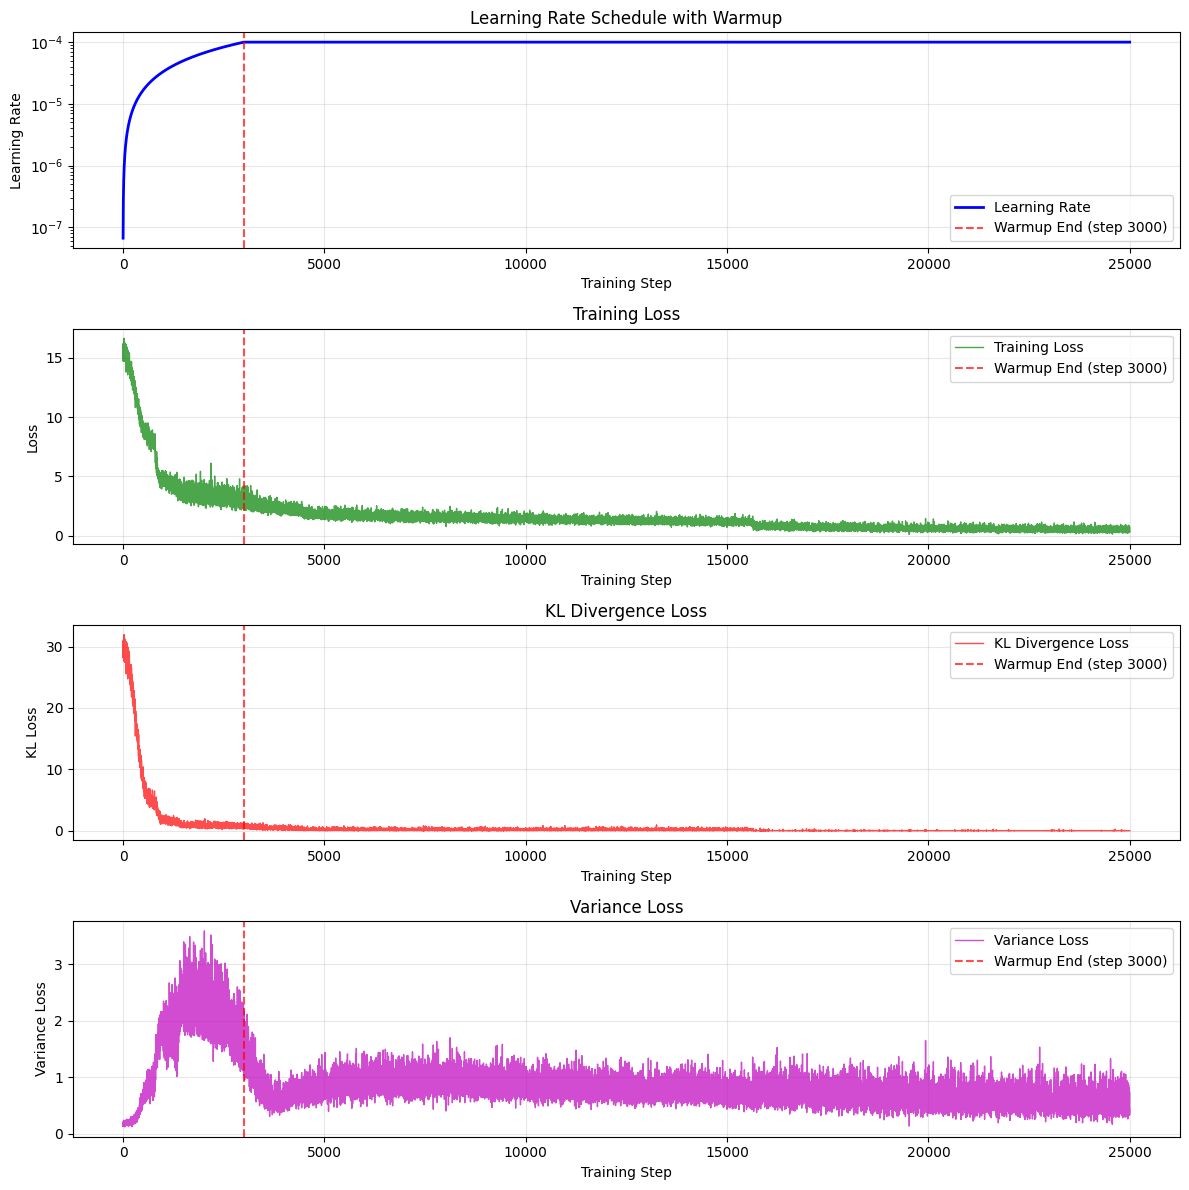


Learning Rate Statistics:
Initial LR: 0.00000007
LR at warmup end (step 3000): 0.00010000
Final LR: 0.00010000
Target LR: 0.00010000


In [17]:
# Start training
train_discrete_model_notebook(num_epochs=25_000, n_plot=8500, plot_dir="./plots", start_epoch=0)

Learnt beta_1: 4.7377, Scaling: 0.9277


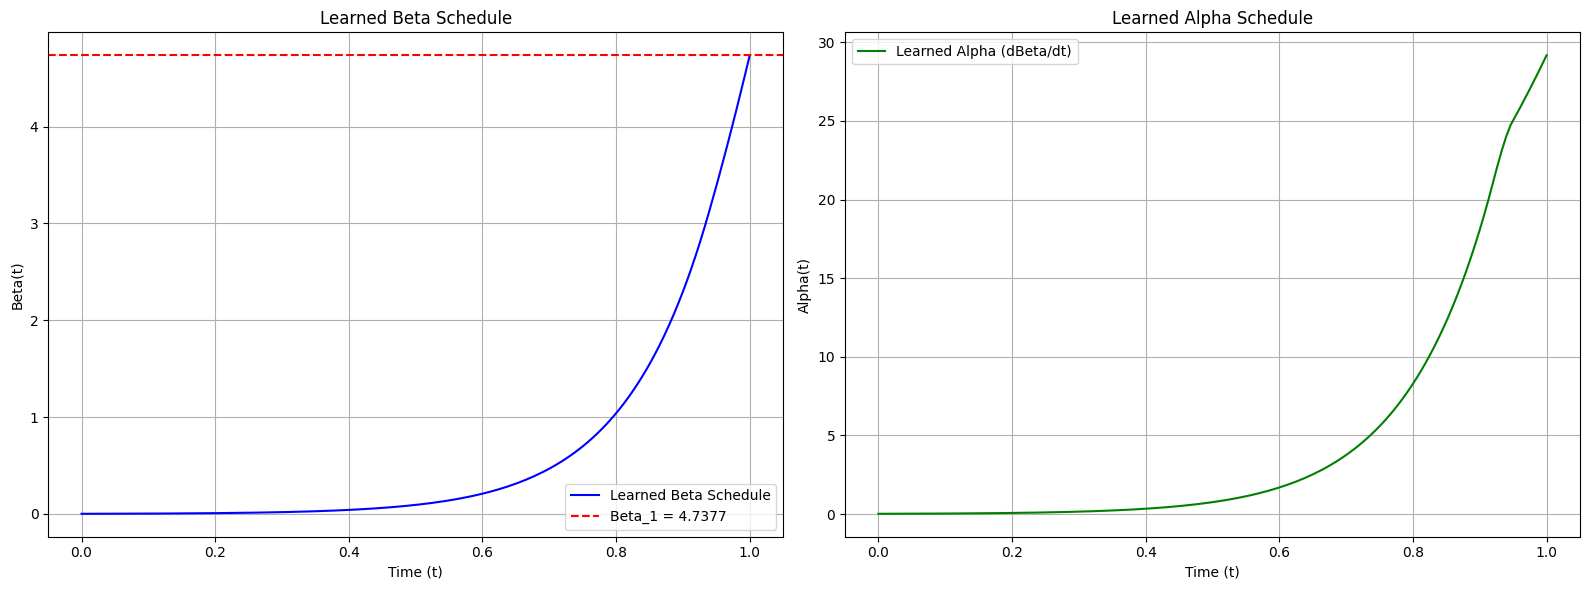

In [18]:
beta_scheduler = model.learnable_beta
t_coords, beta_coords = beta_scheduler.visualize(K=tokenizer.vocab_size(), points=150, device=device)
alpha_t_coords, alpha_coords = beta_scheduler.visualize_alpha(K=tokenizer.vocab_size(), points=150, device=device)
learnt_beta_1 = model.beta_1(K=tokenizer.vocab_size(), device=device).item()
scaling = model.scaling(tokenizer.vocab_size(), device=device)
scaling = scaling.item()

print(f"Learnt beta_1: {learnt_beta_1:.4f}, Scaling: {scaling:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Beta schedule
ax1.plot(t_coords, beta_coords, label='Learned Beta Schedule', color='blue')
ax1.axhline(y=learnt_beta_1, color='red', linestyle='--', label=f'Beta_1 = {learnt_beta_1:.4f}')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Learned Beta Schedule')
ax1.legend()
ax1.grid(True)

# Alpha schedule
ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha (dBeta/dt)', color='green')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Learned Alpha Schedule')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [19]:
def reference_beta_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (- 4 / K) * torch.log(1 - t + t * torch.exp(- K * beta_1 / 4))
def reference_alpha_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (4 / K) * ((1 - torch.exp(- K * beta_1 / 4)) / (1 - t + t * torch.exp(- K * beta_1 / 4)))

In [20]:
ref_beta = reference_beta_schedule(torch.as_tensor(t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha = reference_alpha_schedule(torch.as_tensor(alpha_t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))

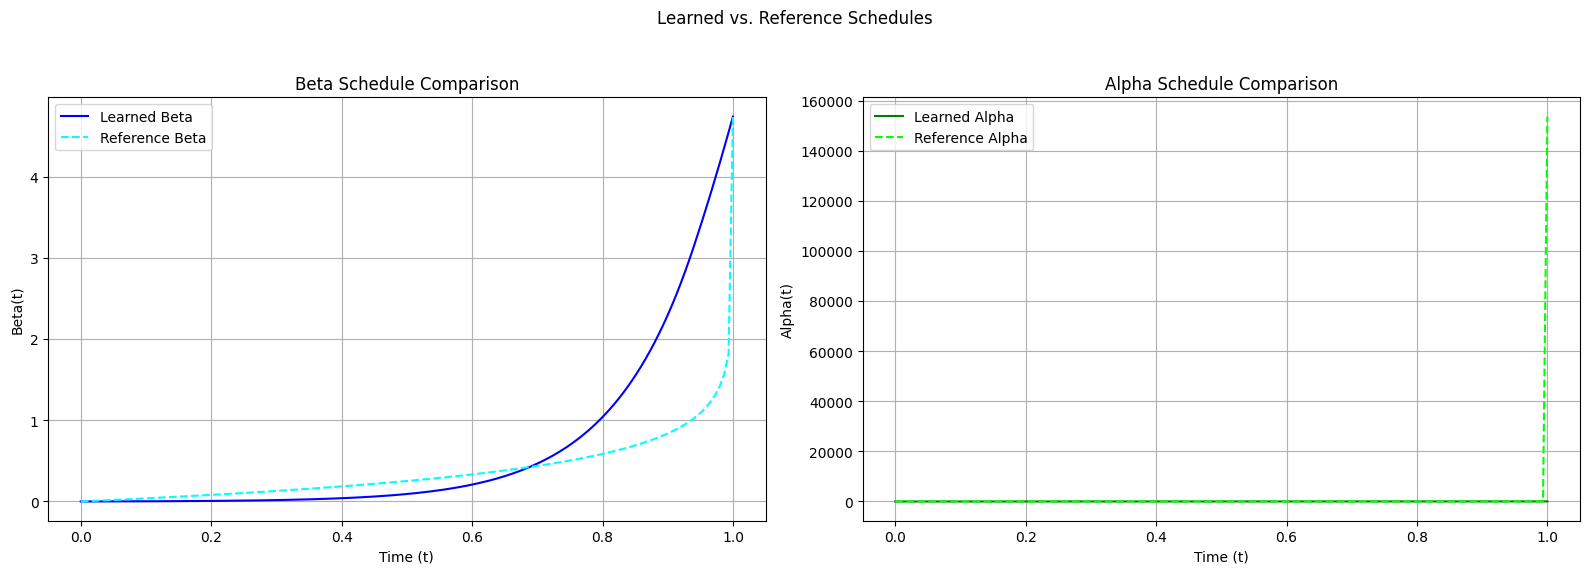

In [ ]:
# t_coords, beta_coords, ref_beta
# alpha_t_coords, alpha_coords, ref_alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Learned vs. Reference Schedules')

# Beta schedule comparison
ax1.plot(t_coords, beta_coords, label='Learned Beta', color='blue')
ax1.plot(t_coords, ref_beta.numpy(), label='Reference Beta', color='cyan', linestyle='--')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Beta Schedule Comparison')
ax1.legend()
ax1.grid(True)

# Alpha schedule comparison
ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha', color='green')
ax2.plot(alpha_t_coords, ref_alpha.numpy(), label='Reference Alpha', color='lime', linestyle='--')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Alpha Schedule Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

[4.91934754e-02 5.53847253e-02 5.97805642e-02 6.27725646e-02
 6.65894449e-02 7.85879269e-02 7.67014101e-02 8.70861858e-02
 8.90528932e-02 1.00250602e-01 1.15557641e-01 1.15197457e-01
 1.22475252e-01 1.45152062e-01 1.48478404e-01 1.70455545e-01
 1.77734911e-01 1.79288521e-01 2.26060405e-01 2.20254555e-01
 2.16431588e-01 1.81667939e-01 2.49043196e-01 2.97965139e-01
 3.10222864e-01 3.88413668e-01 4.59279031e-01 4.28953469e-01
 4.02732670e-01 4.76695925e-01 4.31359828e-01 5.51909745e-01
 5.56135774e-01 6.15640044e-01 7.23577321e-01 7.40604997e-01
 9.56702471e-01 5.85642755e-01 4.57640857e-01 4.91355807e-01
 9.66748595e-01 1.35083675e+00 8.39358807e-01 8.68618786e-01
 1.62519169e+00 9.90974605e-01 4.43318665e-01 6.77798510e-01
 2.01320219e+00 7.89698362e-01 1.36929667e+00 7.04900861e-01
 2.12637615e+00 1.76806545e+00 2.11592674e+00 1.76025355e+00
 5.57215512e-01 3.31007510e-01 3.05536449e-01 1.16422510e+00
 2.72620827e-01 1.47147393e+00 3.42181015e+00 9.00569037e-02
 1.13625508e-02 9.942846

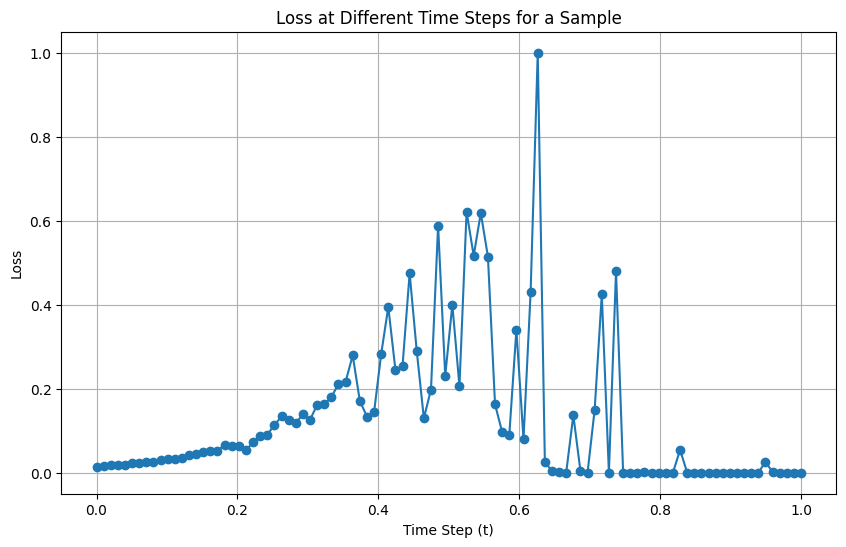

In [30]:
# with torch.no_grad():
# here we take a random sample from the dataset and repeat it on different time steps to see if the loss is uniform at each time step
sample = dataset[0]
sampled_x = sample["x"].unsqueeze(0).to(device)  # Add batch
sampled_x = F.one_hot(sampled_x, num_classes=tokenizer.vocab_size())
sampled_t = torch.linspace(0, 1, 100).to(device) + 1e-8 # Add 100 time steps, prevent 0 using small epsilon
sampled_losses = []
for t in sampled_t:
    sample_output, sample_alpha = model.forward(sampled_x, t.unsqueeze(0))
    # Calculate loss for each time step
    sample_loss, _ = loss(
        alpha=sample_alpha,
        target=sampled_x.float(),
        model_output_logits=sample_output,
        regularization_strength=None
    )
    sampled_losses.append(sample_loss.cpu().item())
sampled_losses = np.array(sampled_losses)

print(sampled_losses)
print(
    f"Variance of losses: {np.var(sampled_losses):.4f}, Standard Deviation: {np.std(sampled_losses):.4f}"
)

sampled_losses = sampled_losses / sampled_losses.max()
plt.figure(figsize=(10, 6))
plt.plot(sampled_t.cpu().detach().numpy(), sampled_losses, marker='o', linestyle='-')
plt.xlabel('Time Step (t)')
plt.ylabel('Loss')
plt.title('Loss at Different Time Steps for a Sample')
plt.grid(True)
plt.show()

In [23]:
n = 250

In [24]:
model_input = torch.normal(0, 1, (1, tokenized_length, tokenizer.vocab_size()), device=device)
model_input = torch.softmax(model_input, dim=-1) * 2 - 1

In [25]:
dis_beta_1 = model.beta_1(K=tokenizer.vocab_size(), device=device)
for i in tqdm(range(1, n + 1)):
    if i % 10 == 0:
        tqdm.write(tokenizer.decode(model_input.squeeze(0)))
    cur_it = torch.tensor([i], device=device)
    total_it = torch.tensor([n], device=device)
    t = dis_t(cur_it, total_it).to(device)

    current_model_input = model_input.clone()

    model_output, _ = model.forward(model_input, t, inference_mode=True)
    model_input = bayesian_inference(
        model_input, model_output, cur_it, total_it, tokenizer.vocab_size(), model.learnable_beta
    )

tqdm.write("Final model result:")
tqdm.write(tokenizer.decode(model_input.squeeze(0)))

  0%|          | 0/250 [00:00<?, ?it/s]

1 0 0 8 9 7 0 7 3 3 7 0 4 , 2 6 8 1 2 2 2 6 4 8 8 , 1 4 4 4 6 1
1 0 0 0 9 7 0 7 , 3 7 0 4 1 2 6 8 1 2 2 2 6 , 9 3 , 1 2 4 3 6 1
1 0 1 0 9 7 0 2 , 3 7 0 4 , 2 6 5 1 2 6 2 6 , 9 3 , 1 4 7 9 6 4
1 , 1 2 6 9 9 , , , 7 0 4 7 , 6 5 1 2 2 2 6 5 7 , , 1 4 7 9 6 4
9 , 1 2 9 9 0 2 , 2 7 1 7 7 , 4 0 8 2 2 6 0 1 7 , , 1 4 7 9 6 4
8 , 1 0 9 9 0 2 , 1 7 9 7 3 , 2 1 5 7 6 6 1 1 , , , 1 4 0 3 6 4
1 7 1 4 6 9 0 4 , 1 7 9 7 1 , 2 1 , 7 2 6 2 1 , , 7 1 4 0 9 6 4
1 7 , 4 9 , 9 4 , 7 7 0 7 1 , 2 1 1 7 8 2 2 1 , , , , 5 0 , 8 7
1 7 , 2 6 , 3 4 , 7 5 5 7 1 , 2 1 1 7 5 , 2 1 , , 1 , 5 0 , 8 7
1 , , 0 , , 3 4 , 7 5 , 1 1 , , 1 1 3 5 , 2 6 , 4 1 , 7 0 , 8 9
1 , , 0 6 , 7 4 , 7 9 , 1 1 , 7 1 , 4 , , 2 6 , 4 1 , 7 0 , 2 9
1 7 , 0 9 , 2 4 , 2 9 , 1 1 , 7 1 , 2 2 , 2 6 , 2 1 , 1 0 , 2 9
1 0 , 1 8 , 1 7 , 2 9 , 1 1 , 7 1 , 2 2 , 2 6 , 2 1 , 2 0 , 2 6
1 0 , 1 8 , 1 7 , 2 9 , 1 1 , 2 1 , 2 2 , 2 6 , 2 1 , 2 0 , 2 6
1 0 , 1 8 , 1 7 , 2 9 , 2 0 , 2 1 , 2 2 , 2 6 , 2 1 , 2 0 , 2 6
1 5 , 1 8 , 1 7 , 2 9 , 2 0 , 2 2 , 2 2 

Tried various weights for the regularization terms. Usable combinations are as follows:

| Combination | Variance Loss Strength | Divergence Loss Strength | Notes |
|-------------|------------------------|--------------------------|-------|
| A           | 0.1                    | 0.1                      | The loss at different timesteps is relatively uniform from 0.6 to 1.0, but really chaotic elsewhere, especially around 0.35 |
| B           | 0.1                    | 0.2                      | Again, uniform from 0.6 to 1.0, other areas more chaotic, but less so than combination A.|
| C           | 0.1                    | 0.4                      | Similar to combination B, but better, only a handful of peaks at specific timesteps, the other non-uniform areas are less "peaks" and more like "mild rolling hills"|
| D           | 0.1                    | 0.8                      | A close second to combination C. from 0.0 to 0.2 as well as 0.7 to 1.0 is quite smooth, but the chaos from 0.3 to 0.65 or so is much spikier|
| E           | 0.2                    | 0.8                      | Somewhat like combination A, but the peaks aren't as pronounced but they jump up and down a lot |
| F           | 0.4                    | 0.1                      | Again, like combination A, but the peaks seem wider, which is bad |
| G           | 0.4                    | 0.4                      | Some peaks are really pronounced, but still okay I guess |
| H           | 0.8                    | 0.8                      | While more uniform overall, there are some severe spikes around 0.4 to 0.8 |
| I           | 1.2                    | 1.2                      | Like combination H, but with fewer peaks, though when it does peak, it is much more pronounced.|

These are the combinations that give good results at inference time. Without attempting to learn the schedule, we get good results at around 32 thousand steps whereas with learning the schedule (and using these regularization terms), we need ~~96~~ 25 thousand steps to get something similar.

~~Put simply, we need **3 times more steps** when learning the schedule. *Ouch*~~

So it actually looks like we need **fewer** steps, interesting.

Also, it seems are need lower learning rate like `1e-4` along with a few thousand warmup steps, otherwise might not converge (or rather, convergence depends in the random seed when model is initialized and dataloader shuffling, *yuck*)

### Failure Modes

I thought perhaps the variance loss wouldn't be needed, but turns out, if the strength of the variance loss is set to 0, the loss is not automatically made uniform by the other terms (duh, but still wanted to check just in case cause the variance loss takes a bit more compute). Strangely, without it, also get `NaN` weights in the integrand module after many steps. I am not sure if the non-zero variance loss strength actually prevents this or merely makes it so it takes many more steps, but the fact remains that without variance loss, we tend to get `NaN` weights.

Also, if we don't enforce that the integrand network always has positive output, we also get `NaN` weights in the integrand module (which isn't that unexpected)